# Robustness Analysis: Multiplicative vs Additive Errors

This notebook compares the effectiveness of the toggling-frame robustness objective for both multiplicative and additive errors. It's strucuted as follows:
* Imports
* Multiplicative vs Additive Error Comparison for Unitary Smooth Pulse Problem: Here we compare the effect of the toggling frame robustness objective on additive and multiplicative errors without any variational states.
* Adjoint, Toggling, Adjoint + Toggling Comparison: Here we compare the effect of the toggling frame robustness relative to the existing adjoint robustness objective on both additive and multiplicative errors (with variational states)

## Imports and Setup

In [2]:
using Pkg
Pkg.activate(".")
Pkg.develop(path="../../QuantumCollocation.jl")
using Revise
using QuantumCollocation
using Piccolo
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`


In [ ]:
# Problem parameters
T = 100
Δt = 0.2
U_goal = GATES.H
H_drives = [PAULIS.X, PAULIS.Y]
rob_scale = 1 / 8.0
a_bound = 0.2
dda_bound = 0.1
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);

## Multiplicative vs Additive Error Comparison for Unitary Smooth Pulse Problem

#### Setup Problem and Solve

In the cell below we get the non-robust and robust trajectories for the Hamiltonian $H=X$ without adding any errors. Later, we will rollout the fidelity for each trajectory for a system subject to an error. 

In [4]:
# setup problems
# multiplicative case
sys = QuantumSystem(H_drives)
prob = UnitarySmoothPulseProblem(sys, U_goal, T, Δt)
solve!(prob, max_iter=50, print_level=0)

rob_sys = QuantumSystem(H_drives)
rob_prob = UnitarySmoothPulseProblem(rob_sys, U_goal, T, Δt; 
                                    H_err = PAULIS.Z,
                                    activate_rob_loss=true, 
                                    a_bound = a_bound,
                                    dda_bound = dda_bound)
solve!(rob_prob, max_iter=50, print_level=0)

    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

    constructing UnitarySmoothPulsePr

#### Calculate Fidelities

Here, we rollout the fidelity for each trajectory.

In [27]:
mult_err_fids = Float64[]
additive_err_fids = Float64[]
mult_rob_fids = Float64[]
additive_rob_fids = Float64[]

error_magnitudes = [x for x in range(0.001, stop=2*π/80, length=100)]

# calculate fidelities
for ε in error_magnitudes
    println("\nError magnitude ε = $ε")

    # mult case
    H_drive_mult(ε) = (1 + ε) * H_drives
    ∂ₑHₘ = H_drive_mult(ε)
    mult_err_sys = QuantumSystem(H_drive_mult(ε))
    mult_err_fidelity = unitary_rollout_fidelity(prob.trajectory, mult_err_sys)
    push!(mult_err_fids, mult_err_fidelity)
    mult_rob_fidelity = unitary_rollout_fidelity(rob_prob.trajectory, mult_err_sys)
    push!(mult_rob_fids, mult_rob_fidelity)

    # additive case
    # ∂ₑHₐ = PAULIS.X
    H_drift(ε) = ε * (PAULIS.Y)
    H_drive_add = H_drives
    add_err_sys = QuantumSystem(H_drift(ε), H_drive_add)
    add_err_fidelity = unitary_rollout_fidelity(prob.trajectory, add_err_sys)
    push!(additive_err_fids, add_err_fidelity)
    add_rob_fidelity = unitary_rollout_fidelity(rob_prob.trajectory, add_err_sys)
    push!(additive_rob_fids, add_rob_fidelity)
end


Error magnitude ε = 0.001

Error magnitude ε = 0.0017832304680782307

Error magnitude ε = 0.0025664609361564614

Error magnitude ε = 0.003349691404234692

Error magnitude ε = 0.004132921872312923

Error magnitude ε = 0.004916152340391153

Error magnitude ε = 0.005699382808469384

Error magnitude ε = 0.006482613276547614

Error magnitude ε = 0.007265843744625845

Error magnitude ε = 0.008049074212704075

Error magnitude ε = 0.008832304680782306

Error magnitude ε = 0.009615535148860536

Error magnitude ε = 0.010398765616938766

Error magnitude ε = 0.011181996085016998

Error magnitude ε = 0.011965226553095228

Error magnitude ε = 0.012748457021173458

Error magnitude ε = 0.01353168748925169

Error magnitude ε = 0.01431491795732992

Error magnitude ε = 0.01509814842540815

Error magnitude ε = 0.01588137889348638

Error magnitude ε = 0.016664609361564612

Error magnitude ε = 0.017447839829642844

Error magnitude ε = 0.018231070297721072

Error magnitude ε = 0.019014300765799304

Error ma

Below we plot the fidelity (NOT the infidelity) for both types of errors. 

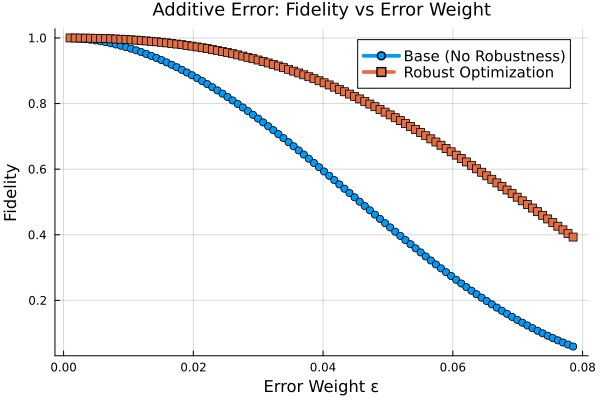

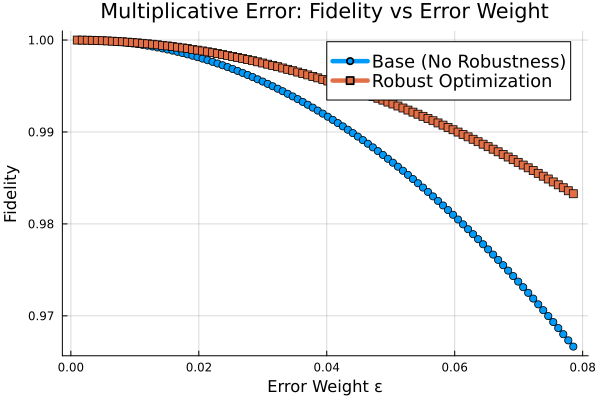


Additive Error Results:
Average base fidelity: 0.5752
Average robust fidelity: 0.8038

Multiplicative Error Results:
Average base fidelity: 0.9889
Average robust fidelity: 0.9943

 Results Table:
Error ε  | Add Err | Add Rob | Mult Err| Mult Rob %
---------------------------------------------------------------------------
  0.001 |   0.9996 |      1.0 |       1.0 |      1.0
 0.0018 |   0.9989 |   0.9999 |       1.0 |      1.0
 0.0026 |   0.9979 |   0.9997 |       1.0 |      1.0
 0.0033 |   0.9964 |   0.9995 |       1.0 |      1.0
 0.0041 |   0.9946 |   0.9992 |       1.0 |   0.9999
 0.0049 |   0.9925 |   0.9989 |    0.9999 |   0.9999
 0.0057 |   0.9899 |   0.9984 |    0.9999 |   0.9999
 0.0065 |    0.987 |    0.998 |    0.9999 |   0.9999
 0.0073 |   0.9838 |   0.9974 |    0.9998 |   0.9998
  0.008 |   0.9802 |   0.9967 |    0.9998 |   0.9998
 0.0088 |   0.9762 |    0.996 |    0.9997 |   0.9998
 0.0096 |   0.9719 |   0.9952 |    0.9996 |   0.9997
 0.0104 |   0.9673 |   0.9943 |    0.99

In [28]:
# Plot 1: Additive Error - Base vs Robust Fidelity
p1 = plot(error_magnitudes, additive_err_fids, 
         label="Base (No Robustness)", 
         marker=:circle, markersize=4, linewidth=3,
         xlabel="Error Weight ε", 
         ylabel="Fidelity",
         title="Additive Error: Fidelity vs Error Weight",
         legendfontsize=10, titlefontsize=12,
         grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3
         )

plot!(p1, error_magnitudes, additive_rob_fids, 
      label="Robust Optimization", 
      marker=:square, markersize=4, linewidth=3,
      linestyle=:dash)

# Plot 2: Multiplicative Error - Base vs Robust Fidelity
p2 = plot(error_magnitudes, mult_err_fids, 
         label="Base (No Robustness)", 
         marker=:circle, markersize=4, linewidth=3,
         xlabel="Error Weight ε", 
         ylabel="Fidelity",
         title="Multiplicative Error: Fidelity vs Error Weight",
         legendfontsize=12, titlefontsize=14,
         grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3
         )

plot!(p2, error_magnitudes, mult_rob_fids, 
      label="Robust Optimization", 
      marker=:square, markersize=4, linewidth=3,
      linestyle=:dash)

display(p1)
display(p2)

# # Summary statistics
println("\nAdditive Error Results:")
println("Average base fidelity: $(round(mean(additive_err_fids), digits=4))")
println("Average robust fidelity: $(round(mean(additive_rob_fids), digits=4))")

println("\nMultiplicative Error Results:")
println("Average base fidelity: $(round(mean(mult_err_fids), digits=4))")
println("Average robust fidelity: $(round(mean(mult_rob_fids), digits=4))")

println("\n Results Table:")
println("Error ε  | Add Err | Add Rob | Mult Err| Mult Rob %")
println("-" ^ 75)
for i in 1:length(error_magnitudes)
    println("$(lpad(round(error_magnitudes[i], digits=4), 7)) | $(lpad(round(additive_err_fids[i], digits=4), 8)) | $(lpad(round(additive_rob_fids[i], digits=4), 8)) | $(lpad(round(mult_err_fids[i], digits=4), 9)) | $(lpad(round(mult_rob_fids[i], digits=4), 8))")
end


In [ ]:
using NamedTrajectories
using PiccoloQuantumObjects
using PiccoloPlots

# plot(rob_prob.trajectory, [:Ũ⃗, :a])
plot_unitary_populations(prob.trajectory)
plot_unitary_populations(rob_prob.trajectory)

## Adjoint, Toggling, Adjoint+Toggling Comparison

In this section, we setup and solve four problems:

1. Adjoint robustness but without the toggle-frame robustness objective (i.e. base case):
    1. Additive error model 
    2. Multiplicative error model
2. With the adjoint and robustness objective 
    1. Additive error model
    2. Multiplicative error model

### Base Case (without toggle-frame robustness objective)

Setup problem to test the performance of the objective using only adjoint robustness (without toggling objective)

In [13]:
# setup problems
# mult case
∂ₑHₘ = H_drive
varsys_mult = VariationalQuantumSystem([H_drive], [H_drive])
mult_base_prob = UnitaryVariationalProblem(
    varsys_mult, U_goal, T, Δt;
    variational_scales=[rob_scale],
    robust_times=[[T]],
    piccolo_options=piccolo_opts
)

# additive case
H_drive_add = PAULIS.X
∂ₑHₐ = PAULIS.X
varsys_add = VariationalQuantumSystem([H_drive_add], [∂ₑHₐ])

# setup base case
add_base_prob = UnitaryVariationalProblem(
    varsys_add, U_goal, T, Δt;
    variational_scales=[rob_scale],
    piccolo_options=piccolo_opts
)

# solve base problems
solve!(mult_base_prob, max_iter=50, print_level=0)
solve!(add_base_prob, max_iter=50, print_level=0)

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt


CompositeException: TaskFailedException

    nested task error: InterruptException:

### Robust Case

Setup problem to test performance when using both adjoint and toggling objectives

In [12]:
# additive case

add_rob_prob = UnitaryVariationalProblem(
        varsys_add, U_goal, T, Δt;
        variational_scales=[rob_scale],
        H_err = H_drive_add,
        activate_rob_loss=true,
        piccolo_options=piccolo_opts
    )

solve!(add_rob_prob, max_iter=50, print_level=0)

# multiplicative case
mult_rob_prob = UnitaryVariationalProblem(
    varsys_mult, U_goal, T, Δt;
    variational_scales=[rob_scale],
    robust_times=[[T]],
    H_err = H_drive,
    activate_rob_loss=true,
    piccolo_options=piccolo_opts
)

# Multiplicative robust case
solve!(mult_rob_prob, max_iter=50, print_level=0)

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt


#### Calculate Infidelity
Here we calculate the INFIDELITY (NOT the fidelity) for all four problems as previously specified.

In [15]:
mult_robust_infids = Float64[]
additive_robust_infids = Float64[]
mult_base_infids = Float64[]
additive_base_infids = Float64[]

error_magnitudes = [x for x in range(0.01, stop=1, length=50)]

# calculate fidelities
for ε in error_magnitudes
    println("\nError magnitude ε = $ε")

    # mult case
    # H_drive_mult(ε) = (1 + ε) * H_drive
    varsys_mult_err = VariationalQuantumSystem([H_drive_mult(ε)], [∂ₑHₘ])

    # mult-base case
    mult_base_fidelity = unitary_rollout_fidelity(mult_base_prob.trajectory, varsys_mult_err)
    push!(mult_base_infids, 1 - mult_base_fidelity)
    
    # mult-robust case
    mult_rob_fidelity = unitary_rollout_fidelity(mult_rob_prob.trajectory, varsys_mult_err)
    push!(mult_robust_infids, 1 - mult_rob_fidelity)

    # additive base case
    H_drift(ε) = ε * PAULIS.X
    varsys_add_err = VariationalQuantumSystem(H_drift(ε), [H_drive_add], [∂ₑHₐ])

    add_base_fidelity = unitary_rollout_fidelity(add_base_prob.trajectory, varsys_add_err)
    push!(additive_base_infids, 1 - add_base_fidelity)

    # Additive robust case
    add_rob_fidelity = unitary_rollout_fidelity(add_rob_prob.trajectory, varsys_add_err)
    push!(additive_robust_infids, 1 - add_rob_fidelity)
end


Error magnitude ε = 0.01

Error magnitude ε = 0.030204081632653063

Error magnitude ε = 0.05040816326530612

Error magnitude ε = 0.07061224489795918

Error magnitude ε = 0.09081632653061225

Error magnitude ε = 0.1110204081632653

Error magnitude ε = 0.13122448979591836

Error magnitude ε = 0.15142857142857144

Error magnitude ε = 0.1716326530612245

Error magnitude ε = 0.19183673469387755

Error magnitude ε = 0.2120408163265306

Error magnitude ε = 0.23224489795918368

Error magnitude ε = 0.2524489795918367

Error magnitude ε = 0.2726530612244898

Error magnitude ε = 0.29285714285714287

Error magnitude ε = 0.3130612244897959

Error magnitude ε = 0.333265306122449

Error magnitude ε = 0.35346938775510206

Error magnitude ε = 0.3736734693877551

Error magnitude ε = 0.39387755102040817

Error magnitude ε = 0.41408163265306125

Error magnitude ε = 0.4342857142857143

Error magnitude ε = 0.45448979591836736

Error magnitude ε = 0.4746938775510204

Error magnitude ε = 0.49489795918367346


#### Plotting

We have three plots 
1. Plots the fidelity of both the base and robust cases for additive error with respect to the weight of the error
2. Plots the fidelity of both the base and robust cases for multiplicative error with respect to the weight of the error
3. Compares the relative improvement in fidelity for the additive v multiplcative error when including robustness objective 

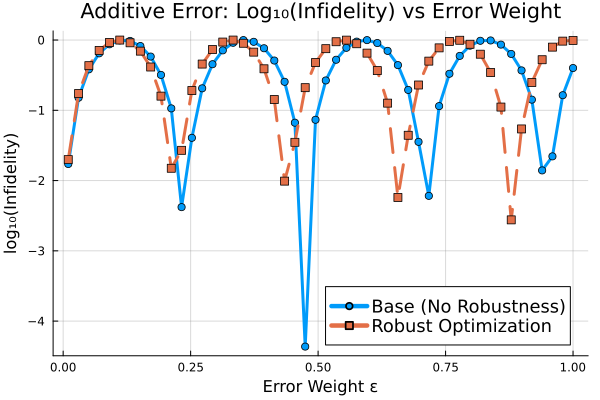

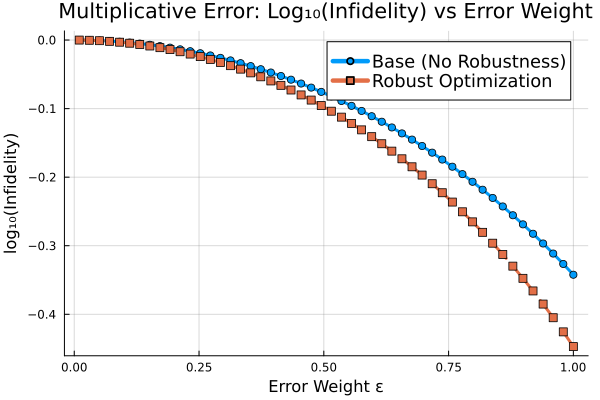

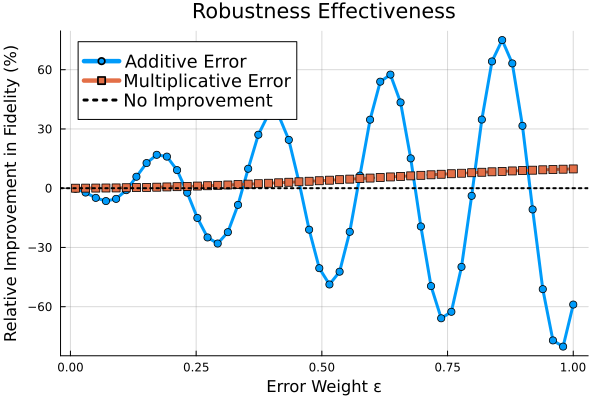


Additive Error Results:
Average base infidelity: 0.4811
Average robust infidelity: 0.5083
Average improvement: -2.72%
Max improvement: 75.01%

Multiplicative Error Results:
Average base infidelity: 0.7962
Average robust infidelity: 0.7535
Average improvement: 4.27%
Max improvement: 9.75%

Comparison:
 Multiplicative errors benefit more from robust optimization
  Difference: 6.99% better

 Results Table:
Error ε  | Add Base | Add Rob  | Add Imp% | Mult Base| Mult Rob | Mult Imp%
---------------------------------------------------------------------------
   0.01 |   0.0172 |   0.0199 |     -0.3 |    0.9999 |   0.9999 |       0.0
 0.0302 |   0.1512 |   0.1733 |     -2.2 |    0.9994 |   0.9992 |       0.0
 0.0504 |   0.3828 |   0.4319 |     -4.9 |    0.9982 |   0.9978 |       0.0
 0.0706 |   0.6472 |   0.7124 |     -6.5 |    0.9966 |   0.9957 |       0.1
 0.0908 |   0.8704 |   0.9245 |     -5.4 |    0.9943 |   0.9929 |       0.1
  0.111 |   0.9899 |   0.9999 |     -1.0 |    0.9915 |   0.9

In [16]:
# Plot 1: Additive Error - Base vs Robust Fidelity
p1 = plot(error_magnitudes, log10.(additive_base_infids), 
         label="Base (No Robustness)", 
         marker=:circle, markersize=4, linewidth=3,
         xlabel="Error Weight ε", 
         ylabel="log₁₀(Infidelity)",
         title="Additive Error: Log₁₀(Infidelity) vs Error Weight",
         legendfontsize=12, titlefontsize=14,
         grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3
         )

plot!(p1, error_magnitudes, log10.(additive_robust_infids), 
      label="Robust Optimization", 
      marker=:square, markersize=4, linewidth=3,
      linestyle=:dash)

display(p1)

# Plot 2: Multiplicative Error - Base vs Robust Fidelity
p2 = plot(error_magnitudes, log10.(mult_base_infids), 
         label="Base (No Robustness)", 
         marker=:circle, markersize=4, linewidth=3,
         xlabel="Error Weight ε", 
         ylabel="log₁₀(Infidelity)",
         title="Multiplicative Error: Log₁₀(Infidelity) vs Error Weight",
         legendfontsize=12, titlefontsize=14,
         grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3
         )

plot!(p2, error_magnitudes, log10.(mult_robust_infids), 
      label="Robust Optimization", 
      marker=:square, markersize=4, linewidth=3,
      linestyle=:dash)

display(p2)

# Calculate relative improvements
additive_improvements = [(additive_base_infids[i] - additive_robust_infids[i]) * 100 
                        for i in 1:length(error_magnitudes)]

mult_improvements = [(mult_base_infids[i] - mult_robust_infids[i]) * 100 
                    for i in 1:length(error_magnitudes)]

# Plot 3: Relative Improvement Comparison
p3 = plot(error_magnitudes, additive_improvements, 
         label="Additive Error", 
         marker=:circle, markersize=4, linewidth=3,
         xlabel="Error Weight ε", 
         ylabel="Relative Improvement in Fidelity (%)",
         title="Robustness Effectiveness",
         legendfontsize=12, titlefontsize=14,
         grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3)

plot!(p3, error_magnitudes, mult_improvements, 
      label="Multiplicative Error", 
      marker=:square, markersize=4, linewidth=3,
      linestyle=:dash)

# Add horizontal line at 0% improvement
hline!(p3, [0], linestyle=:dot, linewidth=2, color=:black, label="No Improvement")

display(p3)


# Summary statistics
println("\nAdditive Error Results:")
println("Average base infidelity: $(round(mean(additive_base_infids), digits=4))")
println("Average robust infidelity: $(round(mean(additive_robust_infids), digits=4))")
println("Average improvement: $(round(mean(additive_improvements), digits=2))%")
println("Max improvement: $(round(maximum(additive_improvements), digits=2))%")

println("\nMultiplicative Error Results:")
println("Average base infidelity: $(round(mean(mult_base_infids), digits=4))")
println("Average robust infidelity: $(round(mean(mult_robust_infids), digits=4))")
println("Average improvement: $(round(mean(mult_improvements), digits=2))%")
println("Max improvement: $(round(maximum(mult_improvements), digits=2))%")

# Which error type benefits more from robustness?
avg_add_improvement = mean(additive_improvements)
avg_mult_improvement = mean(mult_improvements)

println("\nComparison:")
if avg_add_improvement > avg_mult_improvement
    println(" Additive errors benefit more from robust optimization")
    println("  Difference: $(round(avg_add_improvement - avg_mult_improvement, digits=2))% better")
else
    println(" Multiplicative errors benefit more from robust optimization")
    println("  Difference: $(round(avg_mult_improvement - avg_add_improvement, digits=2))% better")
end

println("\n Results Table:")
println("Error ε  | Add Base | Add Rob  | Add Imp% | Mult Base| Mult Rob | Mult Imp%")
println("-" ^ 75)
for i in 1:length(error_magnitudes)
    println("$(lpad(round(error_magnitudes[i], digits=4), 7)) | $(lpad(round(additive_base_infids[i], digits=4), 8)) | $(lpad(round(additive_robust_infids[i], digits=4), 8)) | $(lpad(round(additive_improvements[i], digits=1), 8)) | $(lpad(round(mult_base_infids[i], digits=4), 9)) | $(lpad(round(mult_robust_infids[i], digits=4), 8)) | $(lpad(round(mult_improvements[i], digits=1), 9))")
end

# plot(add_rob_prob.trajectory, [:Ũ⃗, :a])

In [17]:
using NamedTrajectories
using PiccoloQuantumObjects
using PiccoloPlots

plot(rob_prob.trajectory, [:Ũ⃗, :a])
plot_unitary_populations(traj)

# plot(mult_base_prob.trajectory, [:Ũ⃗, :a])
# plot(add_rob_prob.trajectory, [:Ũ⃗, :a])
# plot(mult_rob_prob.trajectory, [:Ũ⃗, :a])

ErrorException: Cannot convert NamedTrajectory{Float64, (:Ũ⃗, :a, :da, :dda, :Δt), NTuple{5, Int64}, (:a, :da, :dda, :Δt), NTuple{4, Tuple{Vector{Float64}, Vector{Float64}}}, (:Ũ⃗, :a), Tuple{Vector{Float64}, Vector{Float64}}, (:a,), Tuple{Vector{Float64}}, (:Ũ⃗,), Tuple{Vector{Float64}}, (:Ũ⃗, :a, :da, :dda, :Δt), NTuple{5, UnitRange{Int64}}, NTuple{5, Symbol}, Tuple{Symbol, Symbol, Symbol}, Tuple{Symbol, Symbol}, (), Tuple{}, (), Tuple{}, Tuple{}} to series data for plotting